### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lgbloch.viz as viz
from lgbloch.engine import distributions_from_deltas
from lgbloch.lgi import (
    entropic_LGI_three_point,
    standard_LGI_dichotomic_three_point,
    wigner_LGI_dichotomic_three_point,
    entropic_LGI_four_point,
    standard_LGI_dichotomic_four_point,
    wigner_LGI_dichotomic_four_point,
 )

# Initialize global engine state `current_engine` similar to lgbloch.engine._get_engine_env
from lgbloch.engine import spin_ops, projectors_Jz
from bloch4spin.basis import bloch_init
from bloch4spin.evolution import GeneralizedBlochEvolutionMatrix, GeneralizedBlochState
from bloch4spin.observable import GeneralizedBlochObservable

# Choose Hilbert-space dimension
_d = 2
bloch_init(_d)
Jx, Jy, Jz, Jp, Jm = spin_ops(_d)
L_H_mat = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Jy)
L_K_mat = GeneralizedBlochEvolutionMatrix.from_Lindblad(Jm)
rho0 = np.eye(_d, dtype=complex) / _d
r0 = GeneralizedBlochState.from_matrix(rho0)
obs_list = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(_d)]

# Global engine dict used by helper functions above
current_engine = {
    "d": _d,
    "L_mat": L_H_mat + 0.1 * L_K_mat,
    "r0": r0 + 0.0 * Jz,
    "obs_list": obs_list,
}
ATOL = 1e-10

# All helper functions now fetch engine state (L, r0, obs_list) from `current_engine`.

def _engine_kwargs():
    e = current_engine
    return dict(d=e["d"], L_mat=e["L_mat"], r0=e["r0"], obs_list=e["obs_list"])

def bool_LG_three_point(t12, t23):
    deltas = (t12, t23)
    jps = distributions_from_deltas(deltas, **_engine_kwargs())
    e_min = entropic_LGI_three_point(jps)
    s_min = standard_LGI_dichotomic_three_point(jps)
    w_min = wigner_LGI_dichotomic_three_point(jps)
    return [e_min < -ATOL, s_min < -ATOL, w_min < -ATOL]

def bool_LG_four_point(t12, t34):
    t23 = (t12 + t34) / 2
    deltas = (t12, t23, t34)
    jps = distributions_from_deltas(deltas, **_engine_kwargs())
    e_min = entropic_LGI_four_point(jps)
    s_min = standard_LGI_dichotomic_four_point(jps)
    w_min = wigner_LGI_dichotomic_four_point(jps)
    return [e_min < -ATOL, s_min < -ATOL, w_min < -ATOL]

def min_LG_three_point(t):
    deltas = (t, t)
    jps = distributions_from_deltas(deltas, **_engine_kwargs())
    e_min = entropic_LGI_three_point(jps)
    s_min = standard_LGI_dichotomic_three_point(jps)
    w_min = wigner_LGI_dichotomic_three_point(jps)
    return [e_min, 15.0 * s_min, 5.0 * w_min]

def min_LG_four_point(t):
    deltas = (t, t, t)
    jps = distributions_from_deltas(deltas, **_engine_kwargs())
    e_min = entropic_LGI_four_point(jps)
    s_min = standard_LGI_dichotomic_four_point(jps)
    w_min = wigner_LGI_dichotomic_four_point(jps)
    return [e_min, 15.0 * s_min, 5.0 * w_min]

### 并行与性能说明
- `viz` 的网格与曲线评估已内置自动并行：无需设置 `n_jobs` 会根据环境自动选择线程数，并避免与 BLAS(MKL/OpenBLAS) 的内部并行叠加。
- 专业用户可在调用处显式传入 `n_jobs`（如 `n_jobs=8`）覆盖缺省策略。
- 概率分布计算严格采用“侵入式”语义：每个子集独立计算，绝不会用边缘分布求和代替。

### Three-point settings

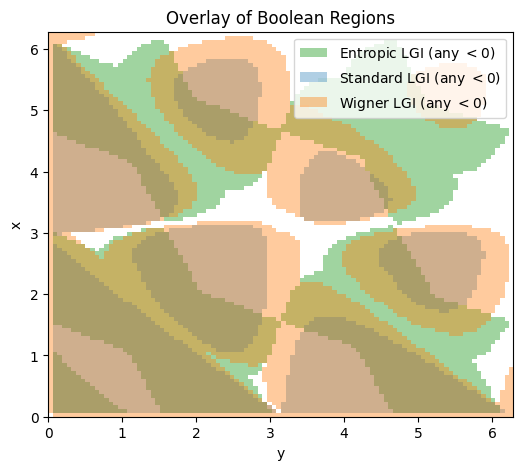

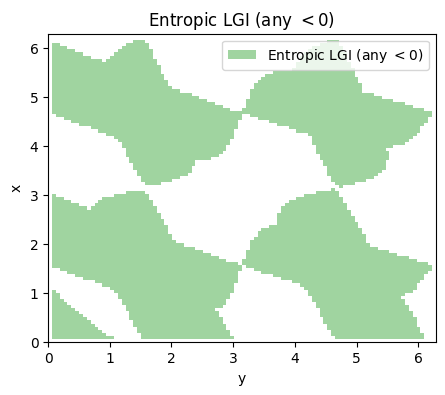

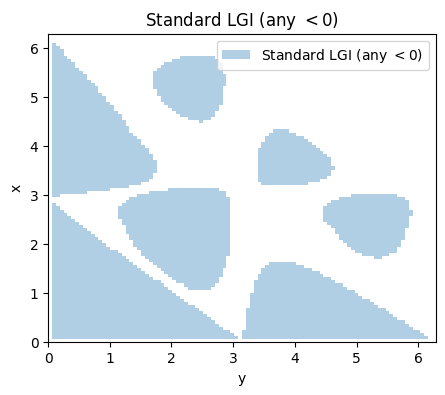

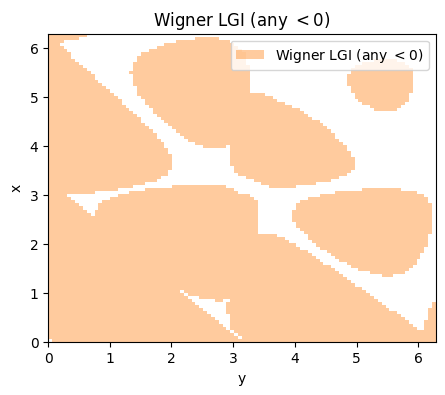

C:\Users\yxh_p\AppData\Local\Temp\ipykernel_14120\304032071.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [2]:
# Multi-output boolean plotting using new viz.plot_boolean_region (merged function)

t12_range = (0.0, 2 * np.pi)
t23_range = (0.0, 2 * np.pi)

# Plot overlay and separate figures in one call (mode='both')
fig_overlay, ax_overlay, separate_figs = viz.plot_boolean_region(
    bool_LG_three_point,
    t12_range,
    t23_range,
    n=100,
    label=[r'Entropic LGI (any $< 0$)', r'Standard LGI (any $< 0$)', r'Wigner LGI (any $< 0$)'],
    color=['tab:green', 'tab:blue', 'tab:orange'],
    alpha=[0.45, 0.35, 0.40],
    mode='both'
)
plt.show()
for fig, ax in separate_figs:
    fig.show()

C:\Users\yxh_p\AppData\Local\Temp\ipykernel_14120\1609038837.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


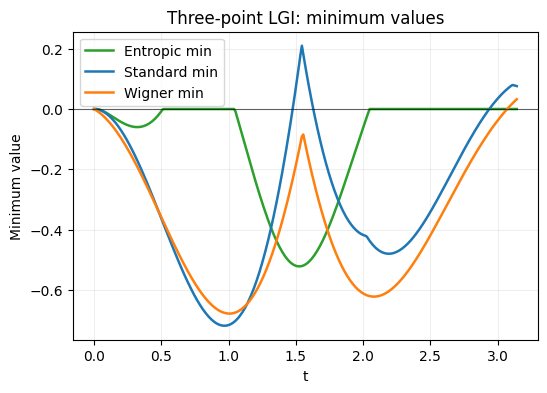

In [ ]:
# Plot minimum values vs t for three-point case
import numpy as np
import matplotlib.pyplot as plt

ts = np.linspace(0.0, 2 * np.pi, 300)
fig, ax = viz.plot_multioutput_curves(
    min_LG_three_point,
    ts,
    label=[r'Entropic min', r'Standard min', r'Wigner min'],
    color=['tab:green', 'tab:blue', 'tab:orange'],
    linewidth=[1.8, 1.8, 1.8],
)
ax.axhline(0.0, color='k', linewidth=0.8, alpha=0.6)
ax.set_xlabel(r't')
ax.set_ylabel('Minimum value')
ax.set_title('Three-point LGI: minimum values')
fig.show()

### Four-point settings

In [ ]:
# Multi-output boolean plotting using new viz.plot_boolean_region (merged function)

t12_range = (0.0, 2 * np.pi)
t34_range = (0.0, 2 * np.pi)

# Plot overlay and separate figures in one call (mode='both')
fig_overlay, ax_overlay, separate_figs = viz.plot_boolean_region(
    bool_LG_four_point,
    t12_range,
    t34_range,
    n=100,
    label=[r'Entropic LGI (all $\geq 0$)', r'Standard LGI (all $\geq 0$)', r'Wigner LGI (all $\geq 0$)'],
    color=['tab:green', 'tab:blue', 'tab:orange'],
    alpha=[0.45, 0.35, 0.40],
    mode='both'
 )
plt.show()
for fig, ax in separate_figs:
    fig.show()

In [ ]:
# Plot minimum values vs t for four-point case
import numpy as np
import matplotlib.pyplot as plt

ts = np.linspace(0.0, 2 * np.pi, 300)
fig, ax = viz.plot_multioutput_curves(
    min_LG_four_point,
    ts,
    label=[r'Entropic min', r'Standard min', r'Wigner min'],
    color=['tab:green', 'tab:blue', 'tab:orange'],
    linewidth=[1.8, 1.8, 1.8],
)
ax.axhline(0.0, color='k', linewidth=0.8, alpha=0.6)
ax.set_xlabel(r't')
ax.set_ylabel('Minimum value')
ax.set_title('Four-point LGI: minimum values')
fig.show()

### Three Level Lambda System

In [ ]:
# Choose Hilbert-space dimension
_d = 3
bloch_init(_d)
E_1 = 0.0
E_2 = 2.58
E_3 = 0.37
omega_12 = 
Jx, Jy, Jz, Jp, Jm = spin_ops(_d)
L_H_mat = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Jy)
L_K_mat = GeneralizedBlochEvolutionMatrix.from_Lindblad(Jm)
rho0 = np.eye(_d, dtype=complex) / _d
r0 = GeneralizedBlochState.from_matrix(rho0)
obs_list = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(_d)]

# Global engine dict used by helper functions above
current_engine = {
    "d": _d,
    "L_mat": L_H_mat + 0.1 * L_K_mat,
    "r0": r0 + 0.0 * Jz,
    "obs_list": obs_list,
}
ATOL = 1e-10